In [1]:
import gymnasium as gym
from gymnasium import spaces
import json
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # 필요한 모듈을 가져옵니다.

from matplotlib.backends.backend_agg import FigureCanvasAgg

In [2]:
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import A2C, PPO, DQN
from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker

from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.logger import configure
from stable_baselines3.common.callbacks import EvalCallback
from sb3_contrib.common.maskable.callbacks import MaskableEvalCallback

In [3]:
from scheduler_env.customEnv_repeat import SchedulingEnv

In [4]:
import warnings
# 특정 경고를 무시하도록 필터를 설정합니다.
warnings.filterwarnings("ignore", category=Warning)

In [5]:
env_2_3_8_2 = SchedulingEnv(machine_config_path= "instances/Machines/v0-2.json", job_config_path = "instances/Jobs/v0-3x12-deadline.json", job_repeats_params = [(8, 2)] * 3)

In [6]:
env_5_8_8_2 = SchedulingEnv(machine_config_path= "instances/Machines/v0-5.json", job_config_path = "instances/Jobs/v0-8x12-deadline.json", job_repeats_params = [(8, 2)] * 8)

In [7]:
env_5_8_8_2_easy = SchedulingEnv(machine_config_path= "instances/Machines/v0-5.json", job_config_path = "instances/Jobs/v0-8x12-deadline-easy.json", job_repeats_params = [(8, 2)] * 8)

In [8]:
env_5_8_5_1 = SchedulingEnv(machine_config_path= "instances/Machines/v0-5.json", job_config_path = "instances/Jobs/v0-8x12-deadline.json", job_repeats_params = [(5, 1)] * 8)

In [9]:
env_5_8_5_1_easy = SchedulingEnv(machine_config_path= "instances/Machines/v0-5.json", job_config_path = "instances/Jobs/v0-8x12-deadline-easy.json", job_repeats_params = [(5, 1)] * 8)

In [10]:
env_5_8_8_2_t = SchedulingEnv(machine_config_path= "instances/Machines/v0-5.json", job_config_path = "instances/Jobs/v0-8x12-deadline.json", job_repeats_params = [(8, 2)] * 8, test_mode = True)

In [11]:
env_8_12_3 = SchedulingEnv(machine_config_path= "instances/Machines/v0-8.json", job_config_path = "instances/Jobs/v0-12-repeat.json", job_repeats_params = [(3, 1)] * 12)

In [12]:
env_8_12_1_t = SchedulingEnv(machine_config_path= "instances/Machines/v0-8.json", job_config_path = "instances/Jobs/v0-12-repeat.json", job_repeats_params = [(1, 1)] * 12, test_mode = True)

In [13]:
env_8_12_8_2 = SchedulingEnv(machine_config_path= "instances/Machines/v0-8.json", job_config_path = "instances/Jobs/v0-12-repeat-hard.json", job_repeats_params = [(8, 2)] * 12)

In [14]:
env_8_12_8_2_t = SchedulingEnv(machine_config_path= "instances/Machines/v0-8.json", job_config_path = "instances/Jobs/v0-12-repeat-hard.json", job_repeats_params = [(8, 2)] * 12, test_mode = True)

In [15]:
env_8_12_8_t_p_30 = SchedulingEnv(machine_config_path= "instances/Machines/v0-8.json", job_config_path = "instances/Jobs/v0-12-repeat-hard.json", profit_per_time = 30, job_repeats_params = [(8, 2)] * 12)

In [16]:
env_16_12_8_2 = SchedulingEnv(machine_config_path= "instances/Machines/v0-16.json", job_config_path = "instances/Jobs/v0-12-repeat-hard.json", job_repeats_params = [(8, 2)] * 12)

In [17]:
env = env_5_8_5_1
check_env(env)

[6, 3, 5, 3, 3, 5, 4, 8]
Current Repeats			:	[6, 3, 5, 3, 3, 5, 4, 8]
Goal reached! Final score	:	27.48
Total revenue			:	2660.00 - 1929.00 = 731.00
Sum of Costs			:	1929.00
Cost Deadline			:	425.00
Cost Hole			:	112.00
Cost Processing			:	532.00
Cost Makespan			:	860.00
Finish Time / Target Time	:	8600 / 5320
Average Tardiness:	1729.73


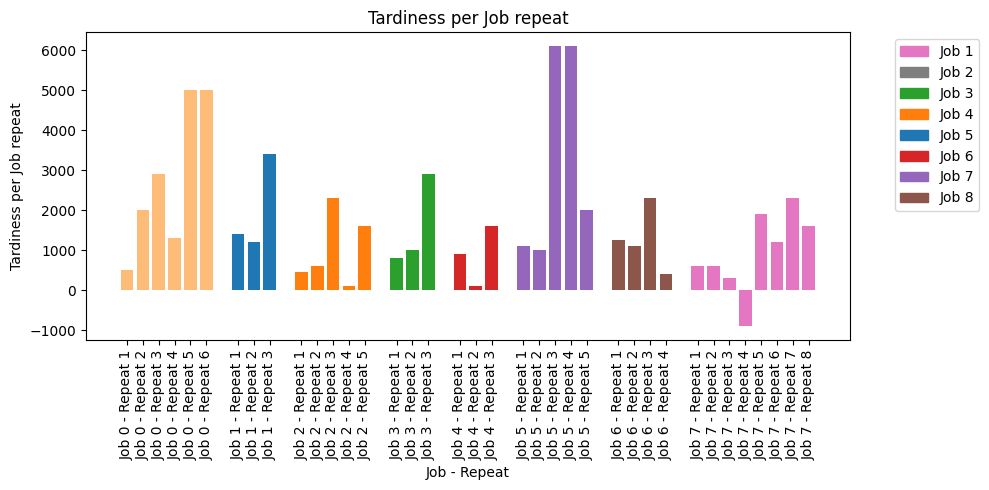

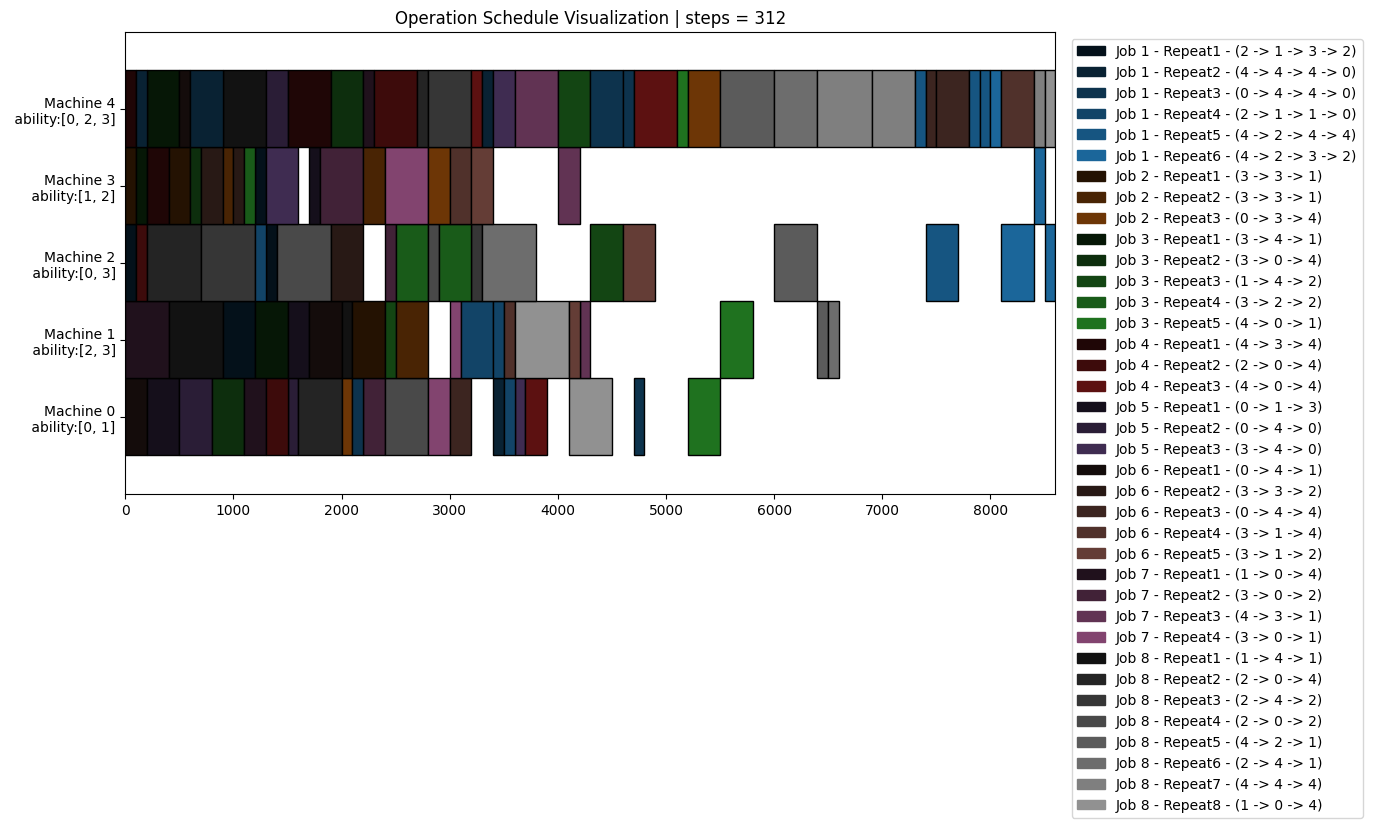

In [18]:
step = 0
obs, info = env.reset()
print(info["current_repeats"])

while True:
    step += 1
    action = env.action_space.sample()    
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    info["reward"] = reward
    info["env"] = env
    info["profit_ratio"] = env.profit_per_time
    
    if done:
        env.print_result(info, detail_mode = False)
        env.render()
        break

In [22]:
log_path = "./logs/tmp/env_5_8_5_1"
# set up logger
new_logger = configure(log_path, ["stdout", "csv", "tensorboard"])

# Create the evaluation environment
eval_env = env
obs, info = eval_env.reset()

# Create the EvalCallback
eval_callback = EvalCallback(eval_env, best_model_save_path=log_path,
                             log_path=log_path, eval_freq=100000,
                             deterministic=True, render=False)

# Create the MaskableEvalCallback
maskable_eval_callback = MaskableEvalCallback(eval_env, best_model_save_path=log_path,
                             log_path=log_path, eval_freq=100000,
                             deterministic=True, render=False)

Logging to ./logs/tmp/env_5_8_5_1


In [20]:
def linear_schedule(initial_value: float, final_value: float):
    def func(progress: float):
        return initial_value + progress * (final_value - initial_value)
    return func

In [21]:
### 하이퍼파라미터 목록
initial_lr = 0.001
final_lr = 0.0003

params = {
    "policy_kwargs" : dict(net_arch=[dict(pi=[256, 256], vf=[256, 256])]),
    "gamma" : 1.0,
    "clip_range" : 0.25,
    "n_steps" : 1024,  
    "learning_rate" : 0.0007,
    }

In [23]:
model = MaskablePPO('MultiInputPolicy', env, verbose=1
                    # clip_range = params["clip_range"],
                    # gamma = params["gamma"],
                    # policy_kwargs = params["policy_kwargs"],
                    # n_steps = params["n_steps"],
                    # learning_rate = params["learning_rate"]
                   )
model.set_logger(new_logger)
model.learn(500000, callback=maskable_eval_callback)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 109      |
|    ep_rew_mean     | 36.9     |
| time/              |          |
|    fps             | 537      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 111         |
|    ep_rew_mean          | 37.4        |
| time/                   |             |
|    fps                  | 498         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011829974 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss   

In [24]:
model.save("MP_test_cost_5_8_5_1_v1")

In [25]:
!tensorboard --logdir=./logs/tmp/env_5_8_5_1

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.14.1 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [27]:
import os
import shutil

log_dir = "./logs/tmp/env_5_8_5_1"

# 디렉토리 내 모든 파일과 서브 디렉토리 삭제
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
    print(f"{log_dir} 디렉토리와 그 안의 모든 내용이 삭제되었습니다.")
else:
    print(f"{log_dir} 디렉토리가 존재하지 않습니다.")

# 디렉토리 재생성 (필요한 경우)
os.makedirs(log_dir, exist_ok=True)
print(f"{log_dir} 디렉토리가 생성되었습니다.")

./logs/tmp/cost_5_8_8 디렉토리와 그 안의 모든 내용이 삭제되었습니다.
./logs/tmp/cost_5_8_8 디렉토리가 생성되었습니다.


In [45]:
# model = MaskablePPO.load("models/MP_test_cost_8_12_8_step")

In [29]:
def random_tardiness_simulation(repeats):
    j = []
    for r in repeats:
        j.append((r, 1))

    test_env = SchedulingEnv(machine_config_path= "instances/Machines/v0-5.json", job_config_path = "instances/Jobs/v0-8x12-deadline.json", job_repeats_params = j, test_mode = True)
    step = 0
    obs, info = test_env.reset()
    while True:
        step += 1
        action = test_env.action_space.sample()    
        obs, reward, terminated, truncated, info = test_env.step(action)
        done = terminated or truncated
        info["reward"] = reward
        info["env"] = test_env
        info["profit_ratio"] = env.profit_per_time
        
        if done:
            env.print_result(info)
            test_env.render()
            break

Current Repeats			:	[4, 5, 4, 5, 5, 5, 4, 4]
Goal reached! Final score	:	54.90
Total revenue			:	2450.00 - 1105.00 = 1345.00
Sum of Costs			:	1105.00
Cost Deadline			:	10.00
Cost Hole			:	25.00
Cost Processing			:	490.00
Cost Makespan			:	580.00
Finish Time / Target Time	:	5800 / 4900
Average Tardiness:	1113.89


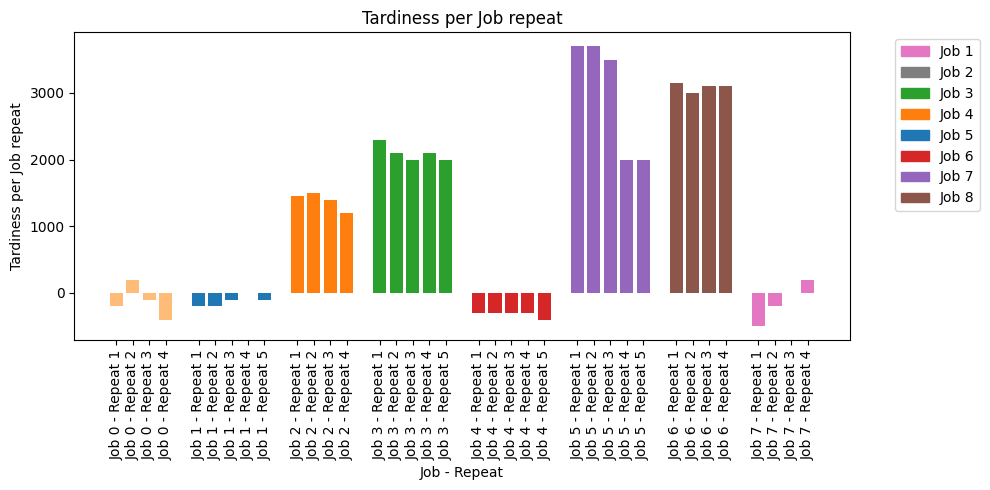

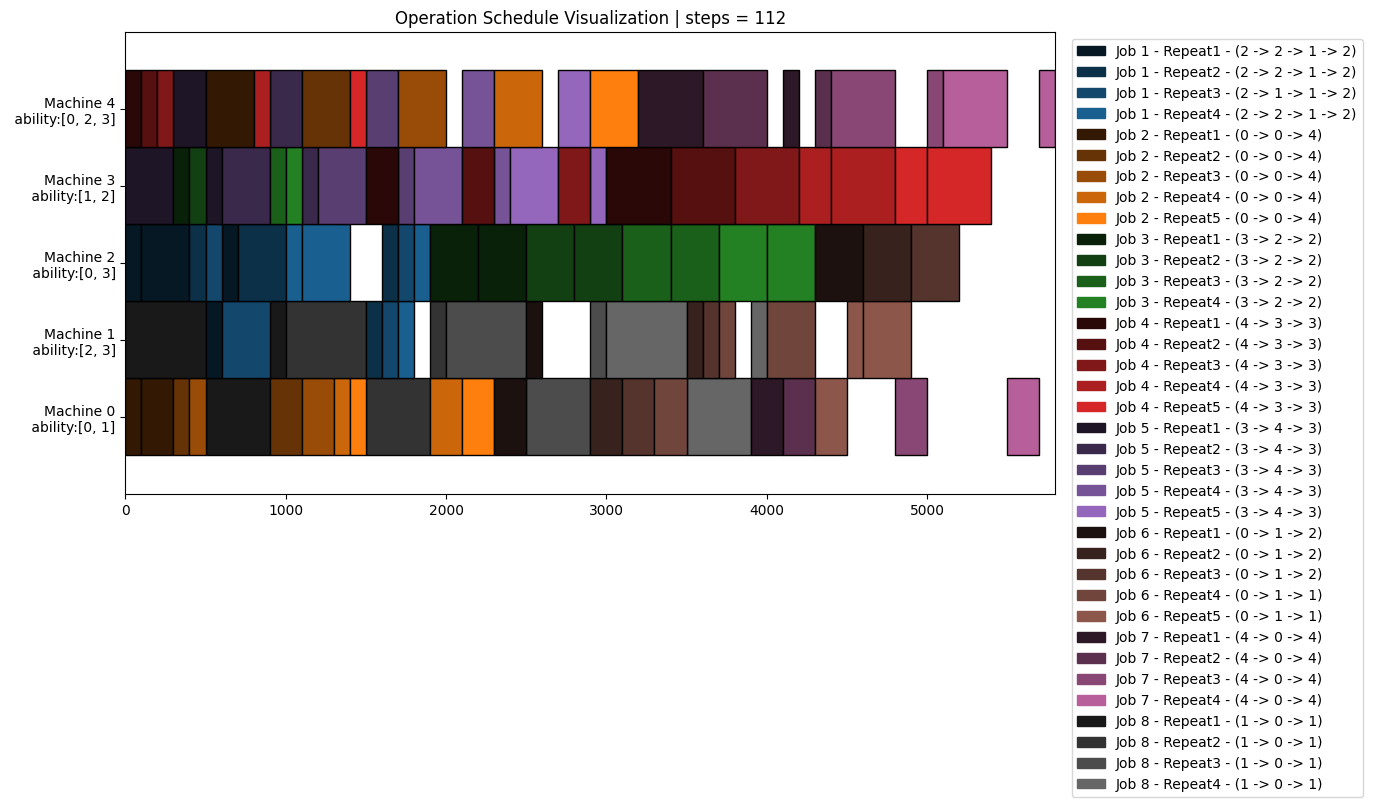




---------------------------Random Simmulation---------------------------
Current Repeats			:	[4, 5, 4, 5, 5, 5, 4, 4]
Goal reached! Final score	:	35.47
Total revenue			:	2450.00 - 1581.00 = 869.00
Sum of Costs			:	1581.00
Cost Deadline			:	205.00
Cost Hole			:	116.00
Cost Processing			:	490.00
Cost Makespan			:	770.00
Finish Time / Target Time	:	7700 / 4900
Average Tardiness:	1877.78


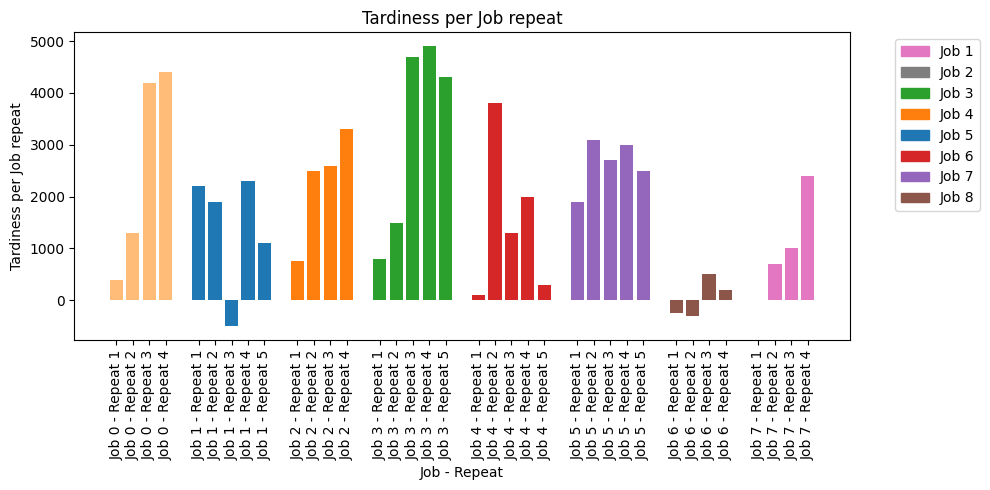

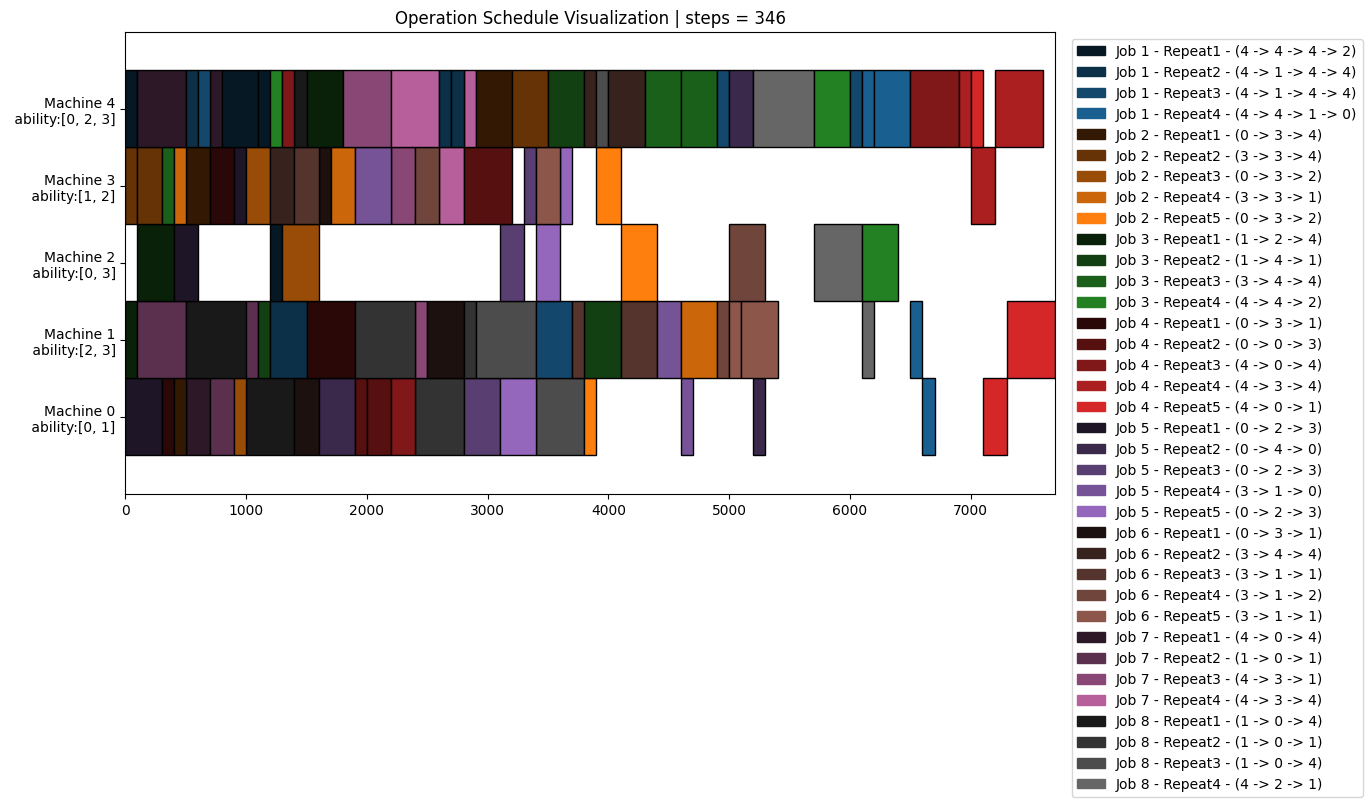

In [32]:
obs, info = env.reset()
while True:
    action_masks = env.action_masks()
    action, _states = model.predict(obs, action_masks=action_masks, deterministic = True)
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    # env.render()
    # print(info["job_estimated_tardiness"])
    if done:    
        info["reward"] = reward
        info["env"] = env
        info["profit_ratio"] = env.profit_per_time
        #print(info["job_estimated_tardiness"])

        env.print_result(info, detail_mode = False)
        env.render()
        break

print()
print()
print()
print("---------------------------Random Simmulation---------------------------")
random_tardiness_simulation(info["current_repeats"])

In [26]:
# job_paths와 machine_paths를 포함하는 목록
job_paths = ["instances/Jobs/v0-12-repeat.json"]
machine_paths = ["instances/Machines/v0-8.json"]

def make_env(job_path, machine_path, test_mode, job_repeats_params):
    def _init():
        env = SchedulingEnv(job_config_path=job_path, machine_config_path=machine_path, job_repeats_params = job_repeats_params, weight_final_time = 50, weight_job_deadline = 50, weight_op_rate = 0, test_mode = test_mode)
        return env
    return _init

envs = [make_env(job_paths[0], machine_paths[0], True, [(3, 1)]*12), make_env(job_paths[0], machine_paths[0], False, [(3, 1)]*12)]

vec_env = SubprocVecEnv(envs)

KeyboardInterrupt: 